# Reproduce DDGemb method

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, EsmModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# path = 'data/'
path = '/content/drive/MyDrive/707/data/'
df_fireprot = pd.read_csv(path + 'fireprotdb_results.csv')

<ipython-input-44-5dd9bfd4d75d>:3: DtypeWarning: Columns (23,24,25,26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fireprot = pd.read_csv(path + 'fireprotdb_results.csv')


In [45]:
df_fireprot.head()

,experiment_id,protein_name,uniprot_id,pdb_id,chain,position,wild_type,mutation,ddG,dTm,...,technique,technique_details,pH,tm,notes,publication_doi,publication_pubmed,hsw_job_id,datasets,sequence
0,LL000001,Haloalkane dehalogenase,P59336,1CQW,A,245,V,L,NaN,2.1,...,NaN,NaN,NaN,52.5,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
1,LL000002,Haloalkane dehalogenase,P59336,1CQW,A,95,L,V,NaN,-0.4,...,NaN,NaN,NaN,50.0,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
2,LL000004,Haloalkane dehalogenase,P59336,1CQW,A,176,C,F,NaN,5.2,...,NaN,NaN,NaN,55.6,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
3,LL000005,Haloalkane dehalogenase,P59336,1CQW,A,171,G,Q,NaN,3.1,...,NaN,NaN,NaN,53.5,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
4,LL000006,Haloalkane dehalogenase,P59336,1CQW,A,148,T,L,NaN,1.1,...,NaN,NaN,NaN,51.5,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...


In [46]:
columns_to_keep = ['experiment_id', 'protein_name', 'uniprot_id', 'pdb_id', 'chain',
       'position', 'wild_type', 'mutation', 'ddG', 'sequence']
df_fireprot = df_fireprot[-df_fireprot['ddG'].isna()]
df_fireprot = df_fireprot[columns_to_keep].drop_duplicates(subset=['experiment_id'])

In [47]:
# Create sequence_wildtype and sequence_mutant columns
df_fireprot.rename(columns={"sequence": "sequence_wildtype"}, inplace = True)
df_fireprot["sequence_mutant"] = df_fireprot["sequence_wildtype"]

# Update sequence_mutant column
for index, row in df_fireprot.iterrows():
    s = list(row["sequence_mutant"])
    s[row["position"]-1] = row["mutation"]
    s = "".join(s)
    df_fireprot.at[index,"sequence_mutant"] = s

In [51]:
X = df_fireprot[["sequence_wildtype", "sequence_mutant"]]
y = df_fireprot["ddG"]

In [52]:
len(X), len(y)

(12131, 12131)

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [78]:
class DDGPredictor(nn.Module):
    def __init__(self,
                 esm_model_name="facebook/esm2_t6_8M_UR50D",
                 embedding_dim=320,
                 conv_channels=128,
                 heads=4,
                 ffn_dim=256):
        super().__init__()

        # Device setup for trainable layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained ESM model on CPU
        self.tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
        self.esm_model = EsmModel.from_pretrained(esm_model_name).eval()
        for param in self.esm_model.parameters():
            param.requires_grad = False

        # Convolutional encoder
        self.conv1d = nn.Conv1d(embedding_dim, conv_channels, kernel_size=3, padding=1)

        # Multi-head attention
        self.attention = nn.MultiheadAttention(embed_dim=conv_channels, num_heads=heads, batch_first=True)

        self.norm1 = nn.LayerNorm(conv_channels)
        self.norm2 = nn.LayerNorm(conv_channels)

        # Position-wise feedforward
        self.ffn = nn.Sequential(
            nn.Linear(conv_channels, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, conv_channels)
        )
        self.dropout = nn.Dropout(0.3)
        # Pooling layers
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        # Regression head
        # self.regressor = nn.Sequential(
        #     nn.Linear(conv_channels * 2, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 1)
        # )
        self.regressor = nn.Sequential(
          nn.Linear(conv_channels * 2, 256),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(256, 64),
          nn.ReLU(),
          nn.Linear(64, 1)
       )

        # Move model parts to appropriate device

    def forward(self, wt_seq, mt_seq):
        # Tokenize and compute embeddings on CPU without gradients
        with torch.no_grad():
            wt_tokens = self.tokenizer(wt_seq, return_tensors="pt", padding=True, truncation=True,max_length=1024)
            mt_tokens = self.tokenizer(mt_seq, return_tensors="pt", padding=True, truncation=True,max_length=1024)

            wt_tokens = {k: v.to(self.device) for k, v in wt_tokens.items()}
            mt_tokens = {k: v.to(self.device) for k, v in mt_tokens.items()}

            wt_embed = self.esm_model(**wt_tokens).last_hidden_state[:, 1:-1, :]  # remove [CLS] and [SEP]
            mt_embed = self.esm_model(**mt_tokens).last_hidden_state[:, 1:-1, :]

            d = (wt_embed - mt_embed) # Move difference to GPU

        # Conv1D (expects B, C, L) and transpose back
        c = self.conv1d(d.transpose(1, 2)).transpose(1, 2)  # (B, L, C)

        # Multi-head attention + residual
        m, _ = self.attention(c, c, c)
        # z = c + m
        z = self.norm1(c + m)

        # Position-wise feedforward + residual
        # ffn_out = self.ffn(z)
        # f = z + ffn_out
        # f = self.norm2(z + self.ffn(z))
        f = self.norm2(z + self.dropout(self.ffn(z)))
        # Global pooling
        f_t = f.transpose(1, 2)  # (B, C, L)
        gp = self.global_avg_pool(f_t).squeeze(-1)  # (B, C)
        gm = self.global_max_pool(f_t).squeeze(-1)  # (B, C)
        conc = torch.cat([gp, gm], dim=1)  # (B, 2C)
        conc = self.dropout(conc)

        # Final regression output
        ddg_pred = self.regressor(conc).squeeze(-1)  # (B,)
        return ddg_pred

In [79]:
#define wt_seqs_batch and mut_seqs_batch, ddG_true
class FireProtDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences.reset_index(drop=True)
        # self.sequences = sequences
        self.targets = targets.reset_index(drop=True)
        # self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        wt = self.sequences.loc[idx, "sequence_wildtype"]
        mt = self.sequences.loc[idx, "sequence_mutant"]
        ddg = self.targets[idx]

        return wt, mt, torch.tensor(ddg, dtype=torch.float32)


In [80]:
batch_size = 16

train_dataset = FireProtDataset(x_train, y_train)
val_dataset   = FireProtDataset(x_val, y_val)
test_dataset  = FireProtDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [84]:
def train_ddg_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # loss_fn = nn.MSELoss()
    loss_fn = nn.HuberLoss(delta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    avg_train_losses = []
    avg_val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for wt_seq, mt_seq, ddg in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            ddg = ddg.to(device)

            # Forward pass (model handles tokenization internally)
            pred = model(wt_seq, mt_seq)  # wt_seq and mt_seq are lists of strings
            loss = loss_fn(pred.squeeze(), ddg)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # torch.cuda.empty_cache()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for wt_seq, mt_seq, ddg in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                ddg = ddg.to(device)
                pred = model(wt_seq, mt_seq)
                loss = loss_fn(pred.squeeze(), ddg)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)
    return avg_train_losses, avg_val_losses


In [85]:
model = DDGPredictor()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
avg_train_losses, avg_val_losses = train_ddg_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4)

Epoch 1 [Train]: 100%|██████████| 607/607 [01:37<00:00,  6.21it/s]


Epoch 1 - Train Loss: 0.8456


Epoch 1 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.22it/s]


Epoch 1 - Val Loss: 0.7328


Epoch 2 [Train]: 100%|██████████| 607/607 [01:37<00:00,  6.21it/s]


Epoch 2 - Train Loss: 0.7155


Epoch 2 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.21it/s]


Epoch 2 - Val Loss: 0.6736


Epoch 3 [Train]: 100%|██████████| 607/607 [01:37<00:00,  6.22it/s]


Epoch 3 - Train Loss: 0.6373


Epoch 3 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.21it/s]


Epoch 3 - Val Loss: 0.6129


Epoch 4 [Train]: 100%|██████████| 607/607 [01:39<00:00,  6.11it/s]


Epoch 4 - Train Loss: 0.5857


Epoch 4 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.22it/s]


Epoch 4 - Val Loss: 0.5639


Epoch 5 [Train]: 100%|██████████| 607/607 [01:36<00:00,  6.27it/s]


Epoch 5 - Train Loss: 0.5460


Epoch 5 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.21it/s]


Epoch 5 - Val Loss: 0.5459


Epoch 6 [Train]: 100%|██████████| 607/607 [01:36<00:00,  6.30it/s]


Epoch 6 - Train Loss: 0.5134


Epoch 6 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.20it/s]


Epoch 6 - Val Loss: 0.5499


Epoch 7 [Train]: 100%|██████████| 607/607 [01:38<00:00,  6.16it/s]


Epoch 7 - Train Loss: 0.4807


Epoch 7 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.22it/s]


Epoch 7 - Val Loss: 0.5105


Epoch 8 [Train]: 100%|██████████| 607/607 [01:37<00:00,  6.24it/s]


Epoch 8 - Train Loss: 0.4654


Epoch 8 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.22it/s]


Epoch 8 - Val Loss: 0.4963


Epoch 9 [Train]: 100%|██████████| 607/607 [01:38<00:00,  6.16it/s]


Epoch 9 - Train Loss: 0.4421


Epoch 9 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.21it/s]


Epoch 9 - Val Loss: 0.5020


Epoch 10 [Train]: 100%|██████████| 607/607 [01:37<00:00,  6.25it/s]


Epoch 10 - Train Loss: 0.4291


Epoch 10 [Val]: 100%|██████████| 76/76 [00:12<00:00,  6.21it/s]

Epoch 10 - Val Loss: 0.4891


In [87]:
file_path_model = "model_ddg_predictor_10_epochs_lr_1e-4_batch_size_16.pth"
torch.save(model.state_dict(), file_path_model)

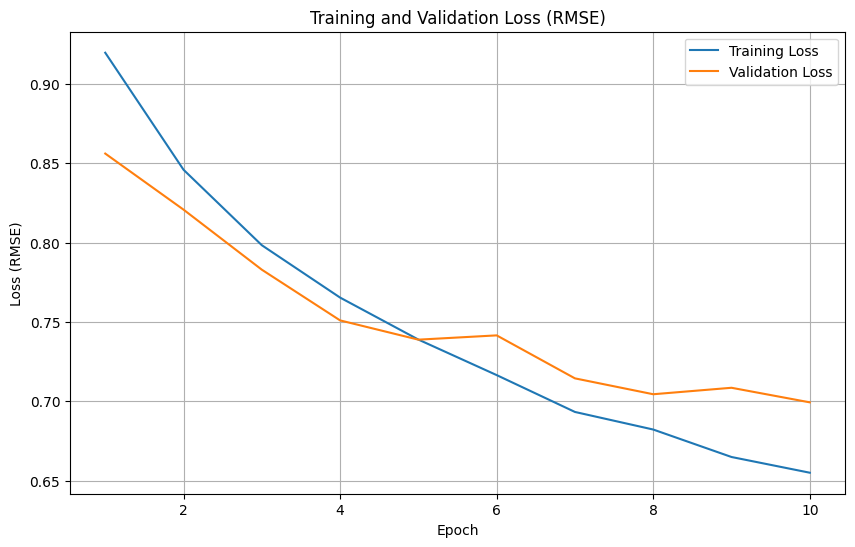

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_train_losses) + 1), np.sqrt(np.array(avg_train_losses)), label='Training Loss')
plt.plot(range(1, len(avg_val_losses) + 1), np.sqrt(np.array(avg_val_losses)), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.title('Training and Validation Loss (RMSE)')
plt.legend()
plt.grid(True)
plt.show()